<a href="https://colab.research.google.com/github/u25723007/MIT805-Semester-Project-Assignment/blob/main/NYC_Tansport_MapReduce_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#****************MIT805 Assigment part 1  *************************
#****************Name: Tankiso Kolobe     *************************
#****************Studen no. 25723007     **************************

This nodebook has four sections:
1. Data Download
2. Normlization and Preprocessing
3. MapReduce functios
4. Visualization

Section 1: Data Download

In [2]:
# Package installation and imports - run this first
import importlib.util, sys, subprocess
packages = [ 'pandas', 'pyarrow', 'requests', 'tqdm',
             'geopandas', 'shapely', 'IPython',
            'fiona', 'pyproj', 'folium', 'meteostat',
           'pathlib', 'datetime', 'collections']
for package_name in packages:
    is_present = importlib.util.find_spec(package_name)
    if is_present is None:
        print(f"{package_name} is not installed")
        !pip install {package_name}
        print(f"{package_name} is now installed")
    else:
        print(f"{package_name} is installed")

pandas is installed
pyarrow is installed
requests is installed
tqdm is installed
geopandas is installed
shapely is installed
IPython is installed
fiona is not installed
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 41.2 MB/s eta 0:00:00
fiona is now installed
pyproj is installed
folium is installed
meteostat is not installed
meteostat is now installed
pathlib is installed
datetime is installed
collections is installed


In [3]:
from pathlib import Path
from datetime import datetime
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pandas as pd
import pandas as pd
from collections import OrderedDict
import time, os
from meteostat import Point, Hourly
from typing import Optional, Tuple
import requests
from IPython.display import display
try:
    from tqdm import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False

In [4]:
years_st = [2023,2024]
url_base = 'https://d37ci6vzurychx.cloudfront.net/trip-data'
datasts = ['fhvhv', 'yellow', 'fhv']   # taxi data sets to be downloaded
months = list(range(1, 13))             # all months of the year
file_formt = 'parquet'                 # TLC shares files as parquet
out_put_rt = Path('data/tlc')          # folder to download data to

start = datetime(min(years_st), 1, 1)      # start time for weather download
end   = datetime(max(years_st), 12, 31, 23, 59)

weather_folder = Path("data/weather/hourly")  # Folder to download weather data to
weather_folder.mkdir(parents=True, exist_ok=True)

skip_flag = True # flag to avoid multiple downloads of the same file
check_remote_size = True  # if no Content-Length from remote server , use local file

out_put_rt.mkdir(parents=True, exist_ok=True)
print('Output root:', out_put_rt.resolve())

Output root: /content/data/tlc


In [5]:
# define url that combines the data link, year, months and extention to get correct data fro TLC
def build_url(dataset: str, year: int, month: int, ext: str) -> str:
    ds = dataset.lower()
    return f"{url_base}/{ds}_tripdata_{year}-{month:02d}.{ext}"

In [6]:
#Return remote Content-Length to compare with local lenth if file has previously been downloaded
def Remote_File_content_length(url: str, timeout: float = 30.0):

    try:
        #request hearder from url and allow redirection
        rqst = requests.head(url, timeout=timeout, allow_redirects=True)
        if rqst.status_code == 200:
            cl = rqst.headers.get("Content-Length") #get actual content lenght header
            return int(cl) if cl is not None else None #convert to int if present; return None if header missing
    except Exception:
        return None
    return None

In [7]:
# function to download file from rmote server
# download file, show progress, retry and save to folder


def data_download(url: str, dest: Path, max_retries: int = 3, backoff: float = 2.0):
    #make sure folder exists
    dest.parent.mkdir(parents=True, exist_ok=True)
    attempt = 0
    while attempt < max_retries: # retries download in cases of network cuts
        try:
            # fetch url, stream to avoind overloding and limit hangeing downloads
            with requests.get(url, stream=True, timeout=60) as r:
                r.raise_for_status() # for http error
                #open folder to write to
                with dest.open("wb") as file:

                    for chunk in r.iter_content(chunk_size=1024*1024): #download in chunks
                        if chunk:
                            file.write(chunk) # write file
            #return bytes size
            return dest.stat().st_size  # success
        except Exception as e:
            attempt += 1
            if attempt >= max_retries:
                print(f"[Download failed] {url} → {e.__class__.__name__}: {e}")
                return None
            time.sleep(backoff ** attempt) #Exponential backoff duration.

In [8]:
# search through local file before downloading and return if found

def find_local_file(out_dir: Path, dataset: str, year: int, month: int, prefer_ext: str = 'parquet'):
    cand = out_dir / f"{dataset}_tripdata_{year}-{month:02d}.parquet"
    return (cand, 'parquet') if cand.exists() else None

In [9]:
# MAIN LOOP
dt_records = []

for yr in years_st: # iteration over the years
    for dtset in datasts: # iteration over datesets or taxi types
        out_pt_directy = out_put_rt / str(yr) / dtset # output folder per and per taxi type
        out_pt_directy.mkdir(parents=True, exist_ok=True)
        for m in months: # iterations in mothns per per dataset

            # If local exists, compare local size to remote size (HEAD)
            existing_file = find_local_file(out_pt_directy, dtset, yr, m, file_formt)
            if skip_flag and existing_file:
                local_path, local_ext = existing_file
                url_same = build_url(dtset, yr, m, local_ext) # url for header check

                remote_size = Remote_File_content_length(url_same)
                local_size  = local_path.stat().st_size # local size for comparison

                #check remote size, compare with local
                if (remote_size is not None and remote_size == local_size) or (remote_size is None and check_remote_size):
                    #update data records
                    dt_records.append(OrderedDict([
                        ('dataset', dtset),
                        ('year', yr),
                        ('month', m),
                        ('format', local_ext),
                        ('filename', str(local_path)),
                        ('size_bytes', local_size),
                    ]))
                    continue
                else:
                    #re-attemt a mismatched file
                    print(f"[Re-download] {local_path.name} (size mismatch: local={local_size}, remote={remote_size})")

            # build url for requsted file
            url = build_url(dtset, yr, m, file_formt)
            dest = out_pt_directy / f"{dtset}_tripdata_{yr}-{m:02d}.{file_formt}" # path for downloaded data
            print('\nDownloading:', url)
            size_bytes = data_download(url, dest) #data download

            if size_bytes is None:
                print(f"[Skip No Remote] Missing {yr}-{m:02d} for {dtset} in {file_formt}.")
                continue
            #add successful download to data records
            dt_records.append(OrderedDict([
                ('dataset', dtset),
                ('year', yr),
                ('month', m),
                ('format', file_formt),
                ('filename', str(dest)),
                ('size_bytes', size_bytes),
            ]))




Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2023-01.parquet

Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2023-02.parquet

Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2023-03.parquet

Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2023-04.parquet

Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2023-05.parquet

Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2023-06.parquet

Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2023-07.parquet

Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2023-08.parquet

Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2023-09.parquet

Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2023-10.parquet

Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tr

In [10]:
#  Write file sizes to CSV and cumpute total size file TLC data
df = pd.DataFrame(dt_records)
#folder for the data per year
record_csv  = out_put_rt / f"data_records_{min(years_st)}_{max(years_st)}_size.csv"
if not df.empty:
    df.to_csv(record_csv, index=False) # write data records to csv
    total_size_GB = df['size_bytes'].sum() / (1024**3) #total size in GB
    print(f'\nData Record Entries: {len(df)}')
    print(f'Total size : {total_size_GB:.2f} GB')
    # group be taxityepe or datas set
    by_ds = (df.groupby(['dataset','format'])['size_bytes'].sum().reset_index())
    by_ds['size_GB'] = by_ds['size_bytes'] / (1024**3)
    display(by_ds[['dataset','format','size_GB']].sort_values('size_GB', ascending=False))
else:
    print(' empty set ')


Data Record Entries: 72
Total size : 12.39 GB


,dataset,format,size_GB
1,fhvhv,parquet,10.800386
2,yellow,parquet,1.237491
0,fhv,parquet,0.356010


In [11]:
# dowload houly weather data for NYC

# NewYork City point (lat, lon).
nyc = Point(40.7128, -74.0060)

print("Fetching hourly weather from Meteostat… (Jan 2023 → Dec 2024)")
weather_hourly = Hourly(nyc, start, end, timezone="America/New_York").fetch()  # fetch hourly weather for NYC

# Partitioned parquet files
weather_hourly = weather_hourly.copy()

weather_hourly["year"]  = weather_hourly.index.year
weather_hourly["month"] = weather_hourly.index.month

saved_files = 0
total_rows = 0
#group by year and month
for (y, m), part in weather_hourly.groupby(["year", "month"], sort=True):
    dest = weather_folder / f"weather_hourly_{y}-{m:02d}.parquet" # parquet file
    if dest.exists(): # avoid redownload
        print(f"[Skip] {dest.name} already exists")
        continue
    # wremove helper columns before writing
    part.drop(columns=["year", "month"]).to_parquet(dest, index=True)
    saved_files += 1
    total_rows += len(part)

print(f"Done. {saved_files} files saved, {total_rows:,} rows total under {weather_folder}")

Fetching hourly weather from Meteostat… (Jan 2023 → Dec 2024)
Done. 24 files saved, 17,544 rows total under data/weather/hourly


In [12]:
#down load and safe zone look up table csv file

def download_loopup_file(url: str, dest: Path):
    dest.parent.mkdir(parents=True, exist_ok=True)
    remote = Remote_File_content_length(url)
    if dest.exists():
        local = dest.stat().st_size # loca file size
        if (remote and remote == local) or (remote is None): # skip if local file already exist

            return
        print(f"[Re-download] {dest.name} (local {local} vs remote {remote})")
    print("Downloading:", url)
    #perform a http request
    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        with open(dest, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024*1024):
                if chunk:
                    f.write(chunk)
    print(f"[OK] {dest.name} → {dest.stat().st_size:,} bytes")


In [13]:
geo_data_dir = Path("data/geo")
geo_data_dir.mkdir(parents=True, exist_ok=True)

url_look_table = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv"
url_zone_shape  = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"  # Shapefile zip

zone_lookup_csv = geo_data_dir / "taxi_zone_lookup.csv"
zones_zip  = geo_data_dir / "taxi_zones.zip"
zone_shape  = geo_data_dir / "taxi_zones_shp"

download_loopup_file(url_look_table, zone_lookup_csv)
download_loopup_file(url_zone_shape,  zones_zip)

Downloading: https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv
[OK] taxi_zone_lookup.csv → 12,331 bytes
Downloading: https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip
[OK] taxi_zones.zip → 1,025,147 bytes


In [14]:
#print total weather file size and count after download

weather_files = sorted(weather_folder.glob("*.parquet"))

if not weather_files:
    print(f"No weather files found in: {weather_folder.resolve()}")

# Build single-line summary
size_bytes = sum(file.stat().st_size for file in weather_files)
df = pd.DataFrame([{
    "dataset": "weather_hourly",
    "format": "parquet",
    "files": len(weather_files),
    "size_GB": size_bytes / (1024**3),
}])


print(f"Hourly Weather Entries: {len(weather_files)}")
print(f"Total size : {size_bytes / (1024**3):.4f} GB")

display(df[["dataset", "format", "files", "size_GB"]])


Hourly Weather Entries: 24
Total size : 0.0005 GB


,dataset,format,files,size_GB
0,weather_hourly,parquet,24,0.000464


***Section 2 Normalization***

In [15]:
# Run this as first to start spark session

import os

# Insrease driver heap and fewer shuffle partitions to optimize performance
os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--driver-memory 8g "
    "--conf spark.sql.shuffle.partitions=6 "
    "pyspark-shell"
)

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
        .master("local[2]")
        .appName("tlc-fast")
        .config("spark.driver.memory", "8g")
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
        .getOrCreate()
)

JVM max heap (GB): 8.0
Shuffle partitions: 6
Cores in use: 2


In [16]:
#optimize spark session to enable smooth perfance even in a one host environment
spark.conf.set("spark.sql.adaptive.enabled", "true")
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", "true")
spark.conf.set("spark.sql.adaptive.skewJoin.enabled", "true")
spark.conf.set("spark.sql.shuffle.partitions", "12")
spark.conf.set("spark.sql.files.maxPartitionBytes", 64 * 1024 * 1024)  # 64MB
spark.conf.set("spark.sql.files.openCostInBytes", 4 * 1024 * 1024)     # 4MB
#spark.conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
spark.sparkContext.setLogLevel("WARN")
spark.conf.set("spark.sql.files.ignoreCorruptFiles", "true")
spark.conf.set("spark.sql.parquet.mergeSchema", "false")


In [50]:
import os
import glob, re
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
from pyspark.storagelevel import StorageLevel
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
import shutil

In [38]:
# Normalization


RAW_ROOT  = "data/tlc"  #path to the dowloaded data
YEARS     = [2023, 2024] # years to cosider in the datset
DATASETS  = ["fhvhv", "fhv", "yellow"] # three taxi operators datasets

# ---------- helpers ----------
def _first_existing_cols(df, candidates):
    return [F.col(c) for c in candidates if c in df.columns]

def _first_existing_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return F.col(c)
    raise KeyError(f"None of the columns exist: {candidates}")

# ---------- per-dataset normalizers ----------
def norm_fhvhv(df):
    pu = _first_existing_cols(df, ["PULocationID","PUlocationID"])
    do = _first_existing_cols(df, ["DOLocationID","DOlocationID"])
    pk = _first_existing_cols(df, ["pickup_datetime","pickup_time"])
    dr = _first_existing_cols(df, ["dropoff_datetime","dropoff_time","dropOff_datetime"])
    return (
        df.select(
            (F.coalesce(*pu) if pu else F.lit(None)).cast("int").alias("pu_location_id"),
            (F.coalesce(*do) if do else F.lit(None)).cast("int").alias("do_location_id"),
            (F.coalesce(*pk) if pk else F.lit(None)).cast("timestamp").alias("pickup_ts"),
            (F.coalesce(*dr) if dr else F.lit(None)).cast("timestamp").alias("dropoff_ts"),
        )
        .filter(~(F.col("pu_location_id").isNull() & F.col("do_location_id").isNull()))
    )

def norm_fhv(df):
    return (
        df.select(
            F.col("PUlocationID").cast("int").alias("pu_location_id"),
            F.col("DOlocationID").cast("int").alias("do_location_id"),
            F.col("pickup_datetime").cast("timestamp").alias("pickup_ts"),
            F.col("dropOff_datetime").cast("timestamp").alias("dropoff_ts"),
        )
        .filter(~(F.col("pu_location_id").isNull() & F.col("do_location_id").isNull()))
    )

def norm_yellow(df):
    pickup  = _first_existing_col(df, ["tpep_pickup_datetime","pickup_datetime"])
    dropoff = _first_existing_col(df, ["tpep_dropoff_datetime","dropoff_datetime"])
    pu      = _first_existing_col(df, ["PULocationID"])
    do      = _first_existing_col(df, ["DOLocationID"])
    return (
        df.select(
            pu.cast("int").alias("pu_location_id"),
            do.cast("int").alias("do_location_id"),
            pickup.cast("timestamp").alias("pickup_ts"),
            dropoff.cast("timestamp").alias("dropoff_ts"),
        )
        .filter(~(F.col("pu_location_id").isNull() & F.col("do_location_id").isNull()))
    )

NORMALIZERS = {"fhvhv": norm_fhvhv, "fhv": norm_fhv, "yellow": norm_yellow}

# ---------- scan, normalize, and union ----------
parts = []
for ds in DATASETS:
    rx = re.compile(rf"{ds}_tripdata_(\d{{4}})-(\d{{2}})\.parquet$", re.I)
    in_files = []
    for y in YEARS:
        pat = os.path.join(RAW_ROOT, str(y), ds, f"{ds}_tripdata_{y}-*.parquet")
        in_files.extend(sorted(glob.glob(pat)))

    for p in in_files:
        m = rx.search(os.path.basename(p))
        if not m:
            continue
        year, month = int(m.group(1)), int(m.group(2))
        try:
            raw = spark.read.parquet(p)
            norm = NORMALIZERS[ds](raw).withColumn("dataset", F.lit(ds)) \
                                       .withColumn("year",    F.lit(year)) \
                                       .withColumn("month",   F.lit(month))
            parts.append(norm)
        except Exception as e:
            print(f"[skip] {p} → {type(e).__name__}: {str(e)[:160]}")

if not parts:
    raise RuntimeError("No normalized parts created. Check RAW_ROOT/datasets/years.")

# Union all parts (schema-aligned) and cache for reuse
df_norm = parts[0]
for i in range(1, len(parts)):
    df_norm = df_norm.unionByName(parts[i], allowMissingColumns=False)



print("df_norm ready:",
      f"rows≈{df_norm.count():,}",
      "| columns:", df_norm.columns)
# Example peek (cheap)
print("sample:", df_norm.head())


df_norm ready: rows≈579,420,080 | columns: ['pu_location_id', 'do_location_id', 'pickup_ts', 'dropoff_ts', 'dataset', 'year', 'month']
sample: Row(pu_location_id=48, do_location_id=68, pickup_ts=datetime.datetime(2023, 1, 1, 0, 19, 38), dropoff_ts=datetime.datetime(2023, 1, 1, 0, 48, 7), dataset='fhvhv', year=2023, month=1)


In [39]:
# Strict schema audit for df_norm normalization

#column names and datypeys to be chacked
EXPECTED_EXACT = {
    "pu_location_id": "int",
    "do_location_id": "int",
    "pickup_ts":      "timestamp",
    "dropoff_ts":     "timestamp",
}


#  Column presence
missing = [c for c in EXPECTED_EXACT if c not in df_norm.columns]
if missing:
    raise AssertionError(f"Missing required columns in df_norm: {missing}")

#  Exact dtype match
schema_map = {f.name: f.dataType.simpleString() for f in df_norm.schema.fields}
mismatches = [
    (col, schema_map.get(col), EXPECTED_EXACT[col])
    for col in EXPECTED_EXACT
    if schema_map.get(col) != EXPECTED_EXACT[col]
]

if mismatches:
    # Fail with message
    details = "\n".join([f" - {c}: seen={seen}, expected={exp}" for c, seen, exp in mismatches])
    raise TypeError("Schema mismatch in df_norm:\n" + details)

print("df_norm schema is normalized:")
for c in EXPECTED_EXACT:
    print(f" - {c}: {schema_map[c]}")


df_norm schema is normalized:
 - pu_location_id: int
 - do_location_id: int
 - pickup_ts: timestamp
 - dropoff_ts: timestamp


**MapReduce Section**

In [47]:
#

# MAP function: Only the columns we need for pickup
base = df_norm.select("dataset", "year", "month",
                      F.col("pu_location_id").alias("zone"),
                      F.col("pickup_ts").alias("ts"))

# Reduce: Aggregate pickup trips per zone × hour
zone_hour_pick = (
    base
    .where(F.col("ts").isNotNull())
    .withColumn("hour", F.date_trunc("hour", F.col("ts")))
    .groupBy("dataset", "year", "month", "zone", "hour")
    .count()                          #Reduce fucntion
    .withColumnRenamed("count", "trips")
)

print("pickup time zone×hour map done")


pickup time zone×hour map done


In [43]:
# Origin zone to Destination zone map

TIME_KIND = "pickup"              #pick mapin
time_col  = "pickup_ts" if TIME_KIND == "pickup" else "dropoff_ts"

# Map function to only needed cols

df_small = (
    df_norm
      .select("dataset", "year", "month",
              "pu_location_id", "do_location_id", time_col)
      .withColumn("hour", F.date_trunc("hour", F.col(time_col)))

)


# Reduce function: Group once Spark does map-side combine
od_hour = (
    df_small
      .groupBy(         #reduce by kyes
          "dataset","year","month",
          F.col("pu_location_id").alias("pu_zone"),
          F.col("do_location_id").alias("do_zone"),
          "hour"
      )
      .count()  #reduce by count
      .withColumnRenamed("count","trips")
)


print(f"OD flows (by {TIME_KIND} hour) done")


OD flows (by pickup hour) done


In [44]:
# One-time: convert Meteostat hourly parquet to us so that spark can read them Spark-friendly


SRC_DIR = Path("data/weather/hourly")
DST_DIR = Path("data/weather/hourly_us")

# Clean output dir (optional)
if DST_DIR.exists():
    shutil.rmtree(DST_DIR)
DST_DIR.mkdir(parents=True, exist_ok=True)

files = sorted(SRC_DIR.rglob("*.parquet"))
print(f"Found {len(files)} weather parquet files under {SRC_DIR}")

def needs_conversion(schema: pa.Schema) -> bool:
    """Return True if any timestamp column isn't already microseconds."""
    for f in schema:
        t = f.type
        if pa.types.is_timestamp(t) and t.unit != "us":
            return True
    return False

converted = 0

for i, src in enumerate(files, 1):

        pf = pq.ParquetFile(src)
        schema = pf.schema_arrow

        # Mirror tree in destination
        rel = src.relative_to(SRC_DIR)
        dst = DST_DIR / rel
        dst.parent.mkdir(parents=True, exist_ok=True)

        if needs_conversion(schema):
            # all timestamp columns to microseconds
            tbl = pq.read_table(src, memory_map=True)
            pq.write_table(
                tbl, dst,
                compression="snappy",
                coerce_timestamps="us",
                allow_truncated_timestamps=True,  # safe for downcasting ns->us/ms->us
            )
            converted += 1
        else:
            # Already Spark-friendly
            shutil.copy2(src, dst)


print(f" Done: Files  Converted: {converted}")



Found 24 weather parquet files under data/weather/hourly
 Done: Files  Converted: 24


In [45]:
# Citywide hourly pickups using converted timestamp
WEATHER_IN  = "data/weather/hourly_us"   #
OUT_CITYWX  = "out/city_hour_weather"
JOIN_WEATHER = True

#  Pickups only hour-level counts
city_pick = (
    df_norm
      .select("dataset","year","month","pickup_ts")
      .where(F.col("pickup_ts").isNotNull())
      .withColumn("hour", F.date_trunc("hour", F.col("pickup_ts")))
      .groupBy("dataset","year","month","hour")
      .count()
      .withColumnRenamed("count","pickup_trips")
)

# Weather  pre-aggregated by hour and join
if JOIN_WEATHER:
    try:
        wx = (
            spark.read
                 .option("recursiveFileLookup", "true")
                 .parquet(WEATHER_IN)
                 .select("time","temp","prcp", "wspd", "snow")
                 .withColumn("hour", F.date_trunc("hour", F.col("time")))
                 .groupBy("hour")
                 .agg(
                     F.avg("temp").alias("temp"),
                     F.sum("prcp").alias("prcp"),
                     F.avg("wspd").alias("wspd"),
                     F.sum("snow").alias("snow")
                 )
        )
        out = city_pick.join(F.broadcast(wx), ["hour"], "left")
        print("Weather joined (broadcast).")
    except Exception as e:
        print(f"Weather read/join skipped: {e}")
        out = city_pick
else:
    out = city_pick



Weather joined (broadcast).


**Visualization Section**

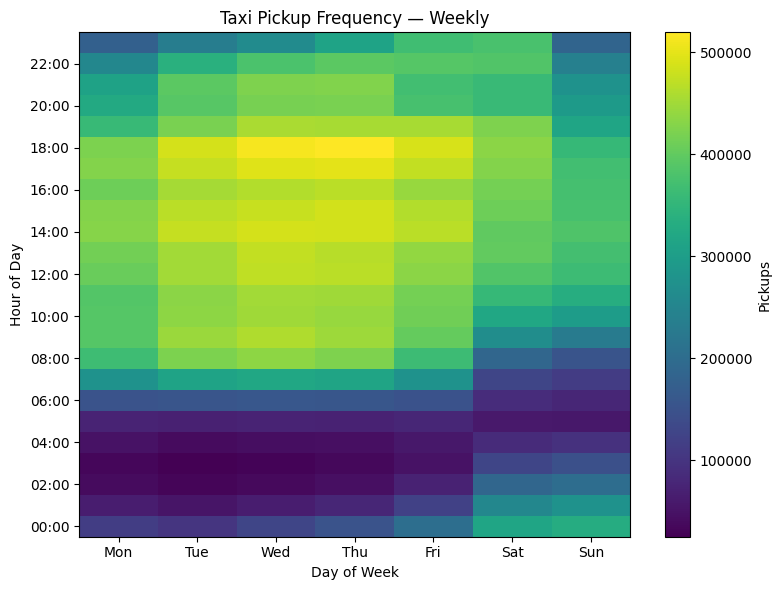

In [53]:
# Weekly pickpus

Z = zone_hour_pick.where((F.col("year").between(2023,2023)) & (F.col("dataset").isin("fhv","yellow"))) # for demo
#Z = zone_hour_pick.select("hour", "trips")  # All datasets and year

# Derive once, then group in Spark
agg = (
    Z.withColumn("dow", ((F.dayofweek("hour") + F.lit(5)) % F.lit(7)) + F.lit(1))  # ISO Mon=1..Sun=7
     .withColumn("hod", F.hour("hour"))
     .groupBy("hod")
     .pivot("dow", list(range(1, 8)))          # columns
     .agg(F.sum("trips"))
     .na.fill(0)                                # fill missing bins
     .orderBy("hod")
)

#
pdf = agg.toPandas()


mat = pdf.drop(columns=["hod"]).to_numpy(dtype=float)  # shape (24, 7)
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(mat, aspect="auto", origin="lower")
ax.set_xticks(np.arange(7)); ax.set_xticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax.set_yticks(np.arange(0,24,2)); ax.set_yticklabels([f"{h:02d}:00" for h in range(0,24,2)])
ax.set_xlabel("Day of Week"); ax.set_ylabel("Hour of Day")
ax.set_title("Taxi Pickup Frequency — Weekly")
plt.colorbar(im, ax=ax, label="Pickups"); plt.tight_layout(); plt.show()


In [33]:
# sacter plots fro trips vs weather conditions

#config
metrics = {
    "prcp": (0.1, "Precipitation", "mm/hr"),
    "wspd": (0.5, "Wind speed",    "m/s"),
    "snow": (0.1, "Snow",          "mm/hr"),
}

# use pickup only
need_cols = ["pickup_trips"] + [c for c in metrics.keys() if c in out.columns]


base = out.select(*need_cols)

# Build DF for ALL metrics
long_bins = None
for col, (step, _, _) in metrics.items():
    if col not in base.columns:
        continue
    xbin = (F.floor(F.col(col) / F.lit(step)) * F.lit(step)).alias("x")
    part = (
        base.select(
            F.lit(col).alias("metric"),
            xbin,
            F.col("pickup_trips").alias("y")
        ).where(F.col("x").isNotNull() & F.col("y").isNotNull())
    )
    long_bins = part if long_bins is None else long_bins.unionByName(part)



# Single aggregation for all metrics
agg_all = (
    long_bins
      .groupBy("metric","x")
      .agg(F.sum("y").alias("pickup_trips"))
)

# Collect  aggregated results per metric and plot
for col, (step, label, unit) in metrics.items():
    if col not in out.columns:
        print(f"(skip) '{col}' not in `out`.")
        continue

    rows = (
        agg_all.where(F.col("metric") == col)
               .orderBy("x")
               .collect()
    )
    if not rows:
        print(f"(skip) No data for '{col}'.")
        continue

    xs = [r["x"] for r in rows]
    ys = [int(r["pickup_trips"]) for r in rows]

    plt.figure(figsize=(8,5))
    plt.scatter(xs, ys, s=12, alpha=0.7)
    plt.xlabel(f"{label} ({unit})")
    plt.ylabel("Hourly pickup trips")
    plt.title(f"Taxi pickups vs {label.lower()}")
    plt.tight_layout()
    plt.show()


'\nfrom pyspark.sql import functions as F\nimport matplotlib.pyplot as plt\n\n# ---- config ----\nmetrics = {\n    "prcp": (0.1, "Precipitation", "mm/hr"),\n    "wspd": (0.5, "Wind speed",    "m/s"),\n    "snow": (0.1, "Snow",          "mm/hr"),\n}\n\n# 0) Keep only what we need (smaller rows -> less IO); cache once if reused\nneed_cols = ["pickup_trips"] + [c for c in metrics.keys() if c in out.columns]\nif "pickup_trips" not in out.columns:\n    raise ValueError("`out` must contain \'pickup_trips\'.")\n\nbase = out.select(*need_cols)  # add .where(...) here to time-slice if desired\n# base = base.cache(); _ = base.take(1)  # uncomment if reusing in same session\n\n# 1) Build a “long” DF for ALL metrics in one pass (union with a metric label)\nlong_bins = None\nfor col, (step, _, _) in metrics.items():\n    if col not in base.columns:\n        continue\n    xbin = (F.floor(F.col(col) / F.lit(step)) * F.lit(step)).alias("x")\n    part = (\n        base.select(\n            F.lit(col).a

In [34]:
# Monthly pickups per dataset (Jan 2023–Dec 2024) from zone_hour_pick

# Aggregate monthly totals in Spark
totals = (
    zone_hour_pick
      .where((F.col("year").isin(2023, 2024)) & (F.col("month").between(1, 12)))
      .groupBy("dataset","year","month")
      .agg(F.sum("trips").alias("trips"))
)

# Create a complete month grid (2023-01 to 2024-12) in Spark
months_df = (
    spark.range(0, 24)
         .select(
             F.add_months(F.to_date(F.lit("2023-01-01")), F.col("id")).alias("month_date")
         )
         .select(
             F.col("month_date"),
             F.year("month_date").alias("year"),
             F.month("month_date").alias("month")
         )
)

# Cross join with all datasets to ensure each dataset has all 24 months
datasets_df = totals.select("dataset").distinct()
grid = datasets_df.crossJoin(months_df)

#Left-join monthly totals onto the full grid and fill missing with 0
full = (
    grid.join(totals, ["dataset","year","month"], "left")
        .fillna({"trips": 0})
        .select("dataset","month_date","trips")
        .orderBy("month_date","dataset")
)

# Collect compact arrays for plotting
rows = full.collect()


all_months = sorted({r["month_date"] for r in rows})
series = {}
for r in rows:
    ds = r["dataset"]
    series.setdefault(ds, {})[r["month_date"]] = int(r["trips"])

# Convert to aligned lists per dataset
x = all_months
y_by_ds = {ds: [series[ds].get(m, 0) for m in x] for ds in series.keys()}

# Plot (single figure, default matplotlib styles/colors)
fig, ax = plt.subplots(figsize=(9, 5))
for ds, y in sorted(y_by_ds.items()):
    ax.plot(x, y, label=ds)

ax.set_title("Monthly Taxi Pickups by Dataset (Jan 2023–Dec 2024)")
ax.set_xlabel("Month")
ax.set_ylabel("Trips")
ax.legend(title="Dataset")
ax.grid(True, axis="y", alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


'\n# 1) Aggregate monthly totals in Spark\ntotals = (\n    zone_hour_pick\n      .where((F.col("year").isin(2023, 2024)) & (F.col("month").between(1, 12)))\n      .groupBy("dataset","year","month")\n      .agg(F.sum("trips").alias("trips"))\n)\n\n# 2) Create a complete month grid (2023-01 to 2024-12) in Spark\nmonths_df = (\n    spark.range(0, 24)\n         .select(\n             F.add_months(F.to_date(F.lit("2023-01-01")), F.col("id")).alias("month_date")\n         )\n         .select(\n             F.col("month_date"),\n             F.year("month_date").alias("year"),\n             F.month("month_date").alias("month")\n         )\n)\n\n# 3) Cross join with all datasets to ensure each dataset has all 24 months\ndatasets_df = totals.select("dataset").distinct()\ngrid = datasets_df.crossJoin(months_df)\n\n# 4) Left-join monthly totals onto the full grid and fill missing with 0\nfull = (\n    grid.join(totals, ["dataset","year","month"], "left")\n        .fillna({"trips": 0})\n        .s


Top-5 Boroughs — totals by dataset

      Borough  yellow   fvh   fvhhv    total gragh
    Manhattan 2715369 68257 7578803 10362429 donut
     Brooklyn   18076 51663 4784586  4854325 donut
       Queens  286645 57433 3666870  4010948 donut
        Bronx    4162 16411 2197976  2218549 donut
Staten Island     341 37136  249800   287277 donut


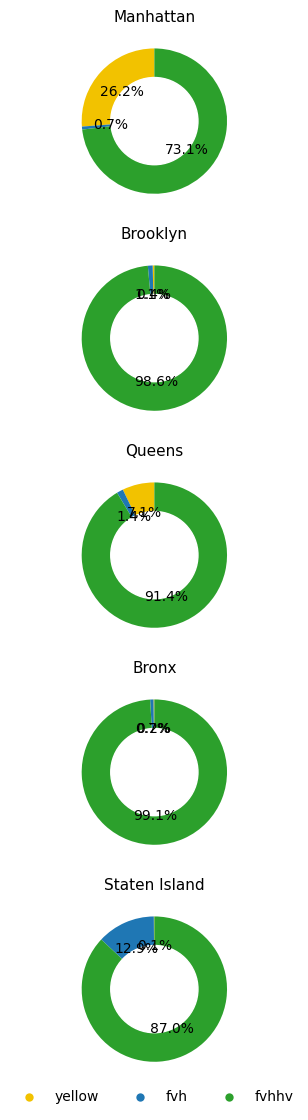

In [36]:
# Top-5 Boroughs — totals by dataset

YEARS  = [2023]     # e.g., [2024] or None
MONTHS = list(range(1,2))# e.g., [1,2,3] or None

df_filt = zone_hour_pick
if YEARS is not None:
    df_filt = df_filt.where(F.col("year").isin([int(y) for y in YEARS]))
if MONTHS is not None:
    df_filt = df_filt.where(F.col("month").isin([int(m) for m in MONTHS]))

# Zones lookup (CSV)
zones_df = (
    spark.read.csv("data/geo/taxi_zone_lookup.csv", header=True, inferSchema=True)
         .select(F.col("LocationID").alias("loc_id"), F.col("Borough").alias("borough"))
         .where(F.col("borough").isNotNull())
)

# Aggregate trips per (zone, dataset) in Spark
zone_ds = (
    df_filt
      .groupBy("zone","dataset")
      .agg(F.sum("trips").alias("trips"))
)

# Join borough, pivot to dataset columns, compute total, pick top 5
top5_sdf = (
    zone_ds.join(zones_df, F.col("zone")==F.col("loc_id"), "inner")
           .groupBy("borough")
           .pivot("dataset", ["yellow","fhv","fhvhv"])
           .agg(F.sum("trips"))
           .na.fill(0)
           .withColumn("total", F.col("yellow")+F.col("fhv")+F.col("fhvhv"))
           .where(F.col("total") > 0)
           .orderBy(F.col("total").desc())
           .limit(5)
           .select("borough","yellow","fhv","fhvhv","total")
)

# Collect  result;
pdf = top5_sdf.toPandas()
pdf = pdf.rename(columns={"borough":"Borough","fhv":"fvh","fhvhv":"fvhhv"})
for c in ["yellow","fvh","fvhhv","total"]:
    pdf[c] = pdf[c].astype(int)

disp = pdf.copy()
disp["gragh"] = "donut"
disp = disp[["Borough","yellow","fvh","fvhhv","total","gragh"]]

print("\nTop-5 Boroughs — totals by dataset\n")
print(disp.to_string(index=False))

# Donut charts
COLORS = {"yellow": "#F2C200", "fvh": "#1f77b4", "fvhhv": "#2ca02c"}

n = len(pdf)
if n > 0:
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(6, 2.2*n))
    if n == 1:
        axes = [axes]

    for ax, row in zip(axes, pdf.itertuples()):
        vals   = [row.yellow, row.fvh, row.fvhhv]
        labels = ["yellow","fvh","fvhhv"]
        colors = [COLORS[k] for k in labels]

        wedges, texts, autotexts = ax.pie(
            vals, startangle=90, colors=colors,
            wedgeprops=dict(width=0.45),
            autopct=lambda p: f"{p:.1f}%" if p > 0 else ""
        )
        ax.add_artist(plt.Circle((0,0), 0.60, color="white"))
        ax.set_title(row.Borough, fontsize=11)
        ax.set(aspect="equal"); ax.axis("off")

    # Legend (color key for donut)
    handles = [
        plt.Line2D([0],[0], marker='o', lw=0, label='yellow', markerfacecolor=COLORS["yellow"], markeredgecolor='none'),
        plt.Line2D([0],[0], marker='o', lw=0, label='fvh',    markerfacecolor=COLORS["fvh"],    markeredgecolor='none'),
        plt.Line2D([0],[0], marker='o', lw=0, label='fvhhv',  markerfacecolor=COLORS["fvhhv"],  markeredgecolor='none'),
    ]
    fig.legend(handles=handles, labels=["yellow","fvh","fvhhv"], loc="lower center",
               ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()
    plt.show()


MapReduce functions